In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from keras.models import load_model
from tensorflow.keras.layers import LSTM, Dense, Bidirectional
import copy

# Load dữ liệu từ file CSV
data = pd.read_csv('Data.csv')

# Chọn window và thuộc tính
window_size = 7
features = [ "Max Temp","Avg Temp" ,"Min Temp","Max Dew Point", "Avg Dew Point","Min Dew Point"]
target = 'Avg Temp'
# Chuẩn bị dữ liệu
x = data[features].values
y = data[target].values

# Chia thành train set và test set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=False)
x_train, y_train = np.array(x_train), np.array(y_train)
# Chuẩn hóa dữ liệu
scaler = MinMaxScaler()
scaler = scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

In [2]:
# Chuyển đổi dữ liệu thành các cửa sổ
trainX = []
trainY = []

for i in range(window_size, len(x_train)+1):
    trainX.append(x_train[i - window_size:i, :])
    trainY.append(x_train[i - 1:i,0])
trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (698, 7, 6).
trainY shape == (698, 1).


In [3]:
testX = []
for i in range(window_size, len(x_test)+1):
    testX.append(x_test[i - window_size:i, :])
testX = np.array(testX)
print('testX shape == {}.'.format(testX.shape))

testX shape == (171, 7, 6).


In [41]:
# Xây dựng mô hình LSTM
model_LSTM = load_model("Bi_LSTM.h5")

In [35]:
model_LSTM.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_2 (Bidirectio  (None, 200)              85600     
 nal)                                                            
                                                                 
 dense_6 (Dense)             (None, 50)                10050     
                                                                 
 dense_7 (Dense)             (None, 5)                 255       
                                                                 
 dense_8 (Dense)             (None, 1)                 6         
                                                                 
Total params: 95,911
Trainable params: 95,911
Non-trainable params: 0
_________________________________________________________________


In [53]:
pred = model_LSTM.predict(testX)


6/6 [==============================] - 0s 4ms/step


In [54]:
prediction_copies = np.repeat(pred, len(features), axis=-1)
predicted = scaler.inverse_transform(prediction_copies)[:,features.index(target)]
print(scaler.inverse_transform(prediction_copies))

[[90.079445 81.616646 74.08828  73.59269  69.49446  61.63683 ]
 [90.7877   82.21079  74.87522  74.41898  70.33648  62.85659 ]
 [88.312805 80.134636 72.12534  71.53161  67.39412  58.594288]
 ...
 [92.8338   83.927246 77.148674 76.80611  72.76908  66.38044 ]
 [92.96333  84.035904 77.29259  76.95722  72.923065 66.60351 ]
 [92.925446 84.00413  77.250496 76.91302  72.87803  66.53827 ]]


In [55]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
Scale = MinMaxScaler()

# Tính và hiển thị MAE
mae = mean_absolute_error(Scale.fit_transform(y_test.reshape(-1, 1)[6:]), Scale.fit_transform(predicted.reshape(-1, 1)))
print("Mean Absolute Error (MAE):", mae)

# Tính và hiển thị MSE
mse = mean_squared_error(Scale.fit_transform(y_test.reshape(-1, 1)[6:]), Scale.fit_transform(predicted.reshape(-1, 1)))
print("Mean Squared Error (MSE):", mse)

# Tính và hiển thị R2
r2=r2_score((y_test[6:]), (predicted))
print("R Square:", r2)

Mean Absolute Error (MAE): 0.08575538624180072
Mean Squared Error (MSE): 0.011123302947587474
R Square: 0.7920697040113098


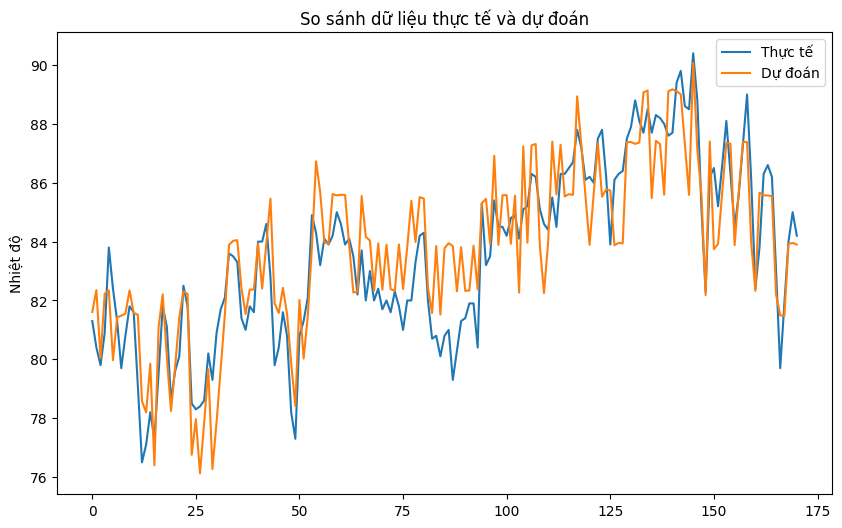

In [40]:
import matplotlib.pyplot as plt

# Tạo array index cho biểu đồ
index = range(len(pred))
# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
plt.plot(index, y_test[6:], label='Thực tế')
plt.plot(index, predicted, label='Dự đoán')
plt.xlabel('')
plt.ylabel('Nhiệt độ')
plt.title('So sánh dữ liệu thực tế và dự đoán')
plt.legend()
plt.show()

In [56]:
# def check_train(model,train_x,train_y):
#   model.fit(train_x,train_y, epochs=5, batch_size=64, verbose=0, shuffle=False)
#   model.reset_states()
#   pred = model.predict(testX)
#   prediction_copies = np.repeat(pred, len(features), axis=-1)
#   predicted = scaler.inverse_transform(prediction_copies)[:,features.index(target)]
#   check = r2_score(y_test[6:], predicted)
#   return check

In [64]:
n_days_for_prediction = 7
window_for_predict = testX[-1:]
predicted_future = []

In [65]:
prediction_copies = np.repeat(pred, len(features), axis=-1)
predicted = scaler.inverse_transform(prediction_copies)

In [66]:
for i in range (0,n_days_for_prediction):
  value_predicted = model_LSTM.predict(window_for_predict)
  # test_model = copy.copy(model_LSTM)
  # if(check_train(test_model,window_for_predict,value_predicted)>r2):
  #   print("change")
  #   model_LSTM.fit(window_for_predict,value_predicted, epochs=5, batch_size=64, verbose=0, shuffle=False)

  value_copy = np.repeat(value_predicted, len(features), axis=-1)
  result_predicted = scaler.inverse_transform(value_copy)
  predicted_future = np.append(predicted_future,result_predicted[:,features.index(target)], axis=0)

  window_for_predict = np.delete(window_for_predict, 0, axis=1)
  window_for_predict = np.append(window_for_predict,np.reshape(value_copy, (1, 1, len(features))), axis=1)

1/1 [==============================] - 0s 31ms/step


<ipython-input-67-58540608ac12>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['Date']=pd.to_datetime(original['Date'])


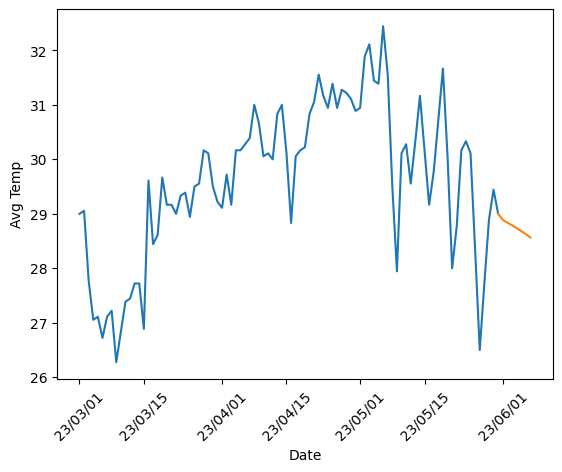

In [67]:
import seaborn as sns
import matplotlib.dates as mdates
original = data[['Date', 'Avg Temp']]
original['Date']=pd.to_datetime(original['Date'])
original = original.loc[original['Date'] >= '2023-3-1']

forecast_period = pd.date_range(list(original['Date'])[-1], periods=n_days_for_prediction+1, freq='1d').tolist()

sns.lineplot(original, x = original['Date'], y = (original['Avg Temp']-32)*(5/9))
sns.lineplot(x = forecast_period, y = (np.insert(predicted_future, 0, y[-1:])-32)*(5/9))
# Định dạng lại nhãn trục x
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%y/%m/%d'))

# Hiển thị biểu đồ
plt.xticks(rotation=45)  # Để xoay nhãn trục x nếu cần

plt.show()